In [5]:
from pyHalo.PresetModels.external import DMFromGalacticus
from pyHalo.Halos.HaloModels.TNFWFromParams import TNFWFromParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
from pyHalo.Halos.galacticus_util.galacticus_util import GalacticusUtil
from pyHalo.Halos.galacticus_util.galacticus_filter import *
from numpy import random
from scipy.optimize import minimize

## Basic Usage

Create a single realization from galacticus output

In [6]:
path_hdf5 = "data/TNFW_example.hdf5"
tree_index = 8
mrange = (1E8,1E10)
# The coordinates of the normal vector of the plane we project onto when rendering
# In this case coordinates would be projected onto y,z plane
plane_normal = np.asarray((1,0,0))
z_lens = 0.5
z_source = 2
cone_opening_angle_arcsec = 10


realization_galacticus = DMFromGalacticus(z_lens,z_source,path_hdf5,tree_index,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                                                                mrange,True,plane_normal)


realization contains 7829 halos.


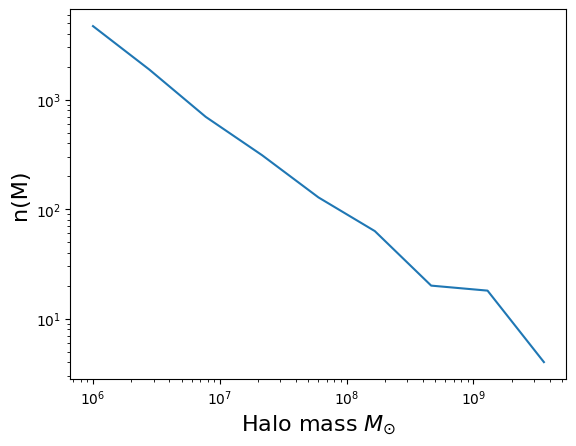

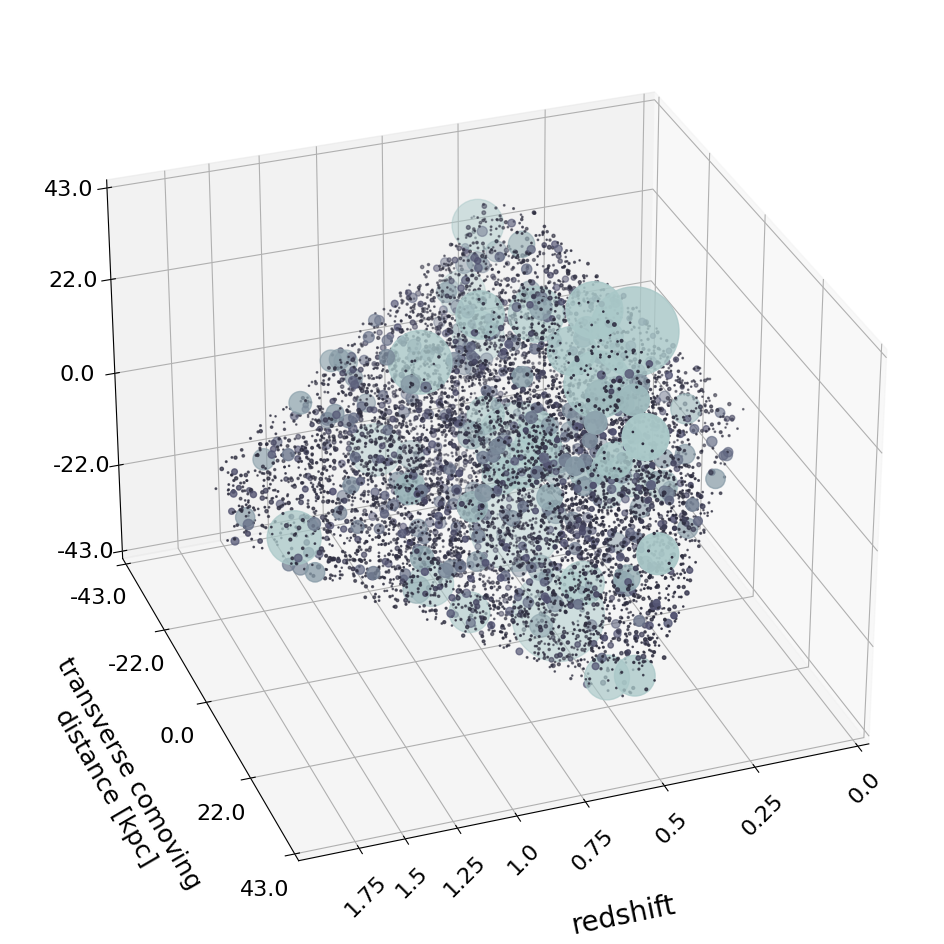

In [7]:
print('realization contains '+str(len(realization_galacticus.halos))+' halos.')
cdm_halo_masses_infall = [halo.mass for halo in realization_galacticus.halos]
N, m = np.histogram(cdm_halo_masses_infall, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realization_galacticus.plot(ax)

Creates multiple realizations for each of the merger trees present in the output

In [8]:
gutil = GalacticusUtil()

# Reads galacticus output into a dictionary of numpy arrays
nodedata = gutil.read_nodedata_galacticus(path_hdf5)

#Get the tree indexes in the galacticus output file
#NOTE: the tree indexes start at one
tree_indexes = np.unique(nodedata[gutil.PARAM_TREE_INDEX])

realization_galacticus_all_trees_sh = []
for i in tree_indexes:
    realization = DMFromGalacticus(z_lens,z_source,path_hdf5,i,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                                                                mrange,True,plane_normal)

    realization_galacticus_all_trees_sh.append(realization)

For the same galacticus tree, create multiple realizations by changing the projection plane. Here we project onto 20 randomly chosen planes.

In [9]:
random.seed(8)

n_projections = 20

theta = np.random.random((n_projections)) * np.pi
phi = np.random.random((n_projections)) * 2 * np.pi

realization_galacticus_multiple_projections = []

for angle in zip(theta,phi):
    realization = DMFromGalacticus(z_lens,z_source,path_hdf5,tree_index,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                                                            mrange,True,proj_rotation_angles=angle)

Visualize properties of galacticus subhalos

Here we switch off feild halos

Single realization

Notes on the mass function graph:
- Sample size of halos is very small
- Graph is of subhalo infall mass
    - Infall mass function is not physical here. If subhalos fall below a given bound mass (in galacticus) they are destroyed. Subhalos that have a small infall mass are more likely to be destroyed, making the infall mass function plot have a non physical turnover.
    - Pyhalo does not use bound / infall mass for calculations, only $r_t$ and $\rho_s$

realization contains 19 halos.


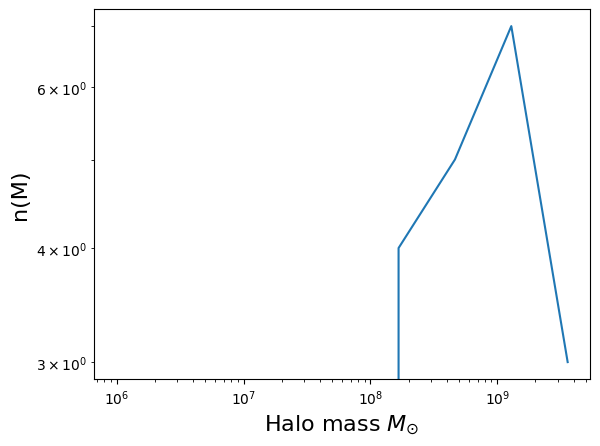

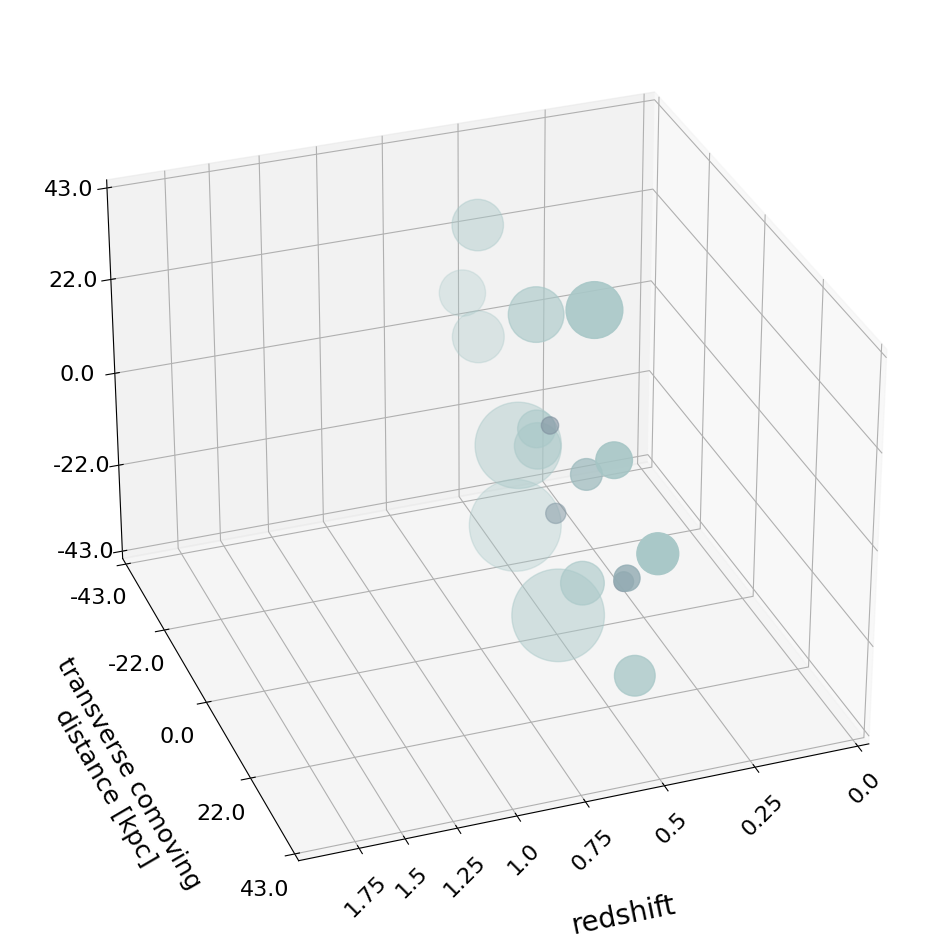

In [10]:
realization_galacticus_subhalos = DMFromGalacticus(z_lens,z_source,path_hdf5,tree_index,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                                                                mrange,True,plane_normal,include_field_halos=False)

subhalos = realization_galacticus_subhalos.halos


print('realization contains '+str(len(realization_galacticus_subhalos.halos))+' halos.')
cdm_halo_masses_infall = [halo.mass for halo in realization_galacticus_subhalos.halos]
N, m = np.histogram(cdm_halo_masses_infall, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realization_galacticus_subhalos.plot(ax)

Properties of all subhalos, all realizations

realization contains 13725 halos.


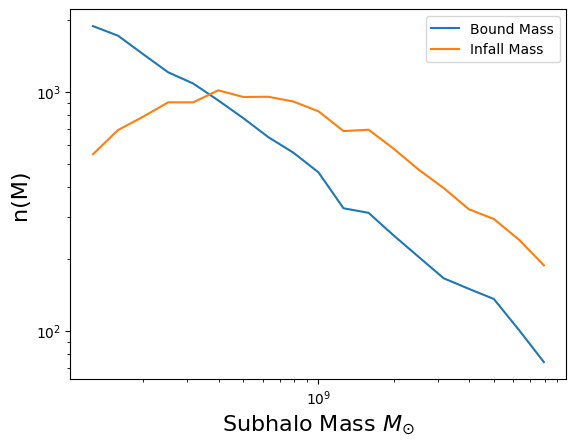

In [11]:
n_projections = 100

theta = np.random.random((n_projections)) * np.pi
phi = np.random.random((n_projections)) * 2 * np.pi

# By default subhalos are filtered such that only subhalos from a particular tree
# and those that are within the rendering volume of the cone are included
# we can override, to include all subhalos in the galacticus file in the realization
# we exclude subhalos outside of the virial radius of their host
# since galacticus is not calibrated for these subhalos, we also include host halos
realization_galacticus_subhalos_all = DMFromGalacticus(z_lens,z_source,path_hdf5,tree_index,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                                                                mrange,True,plane_normal,include_field_halos=False,
                                                                                nodedata_filter=lambda nd,util: nodedata_filter_subhalos(nd,util) & nodedata_filter_virialized(nd,util))


sub_halos = realization_galacticus_subhalos_all.halos

print('realization contains '+str(len(sub_halos))+' halos.')
cdm_halo_masses_bound = [halo.bound_mass for halo in sub_halos]
cdm_halo_masses_infall = [halo.mass for halo in sub_halos]
n_bound, m_bound = np.histogram(cdm_halo_masses_bound, bins=np.logspace(8.1, 10, 20))
n_infall, m_infall = np.histogram(cdm_halo_masses_infall, bins=np.logspace(8.1, 10, 20))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.plot(m_bound[0:-1], n_bound, label="Bound Mass")
ax.plot(m_infall[0:-1], n_infall, label="Infall Mass")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Subhalo Mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)
ax.legend()

Fitting

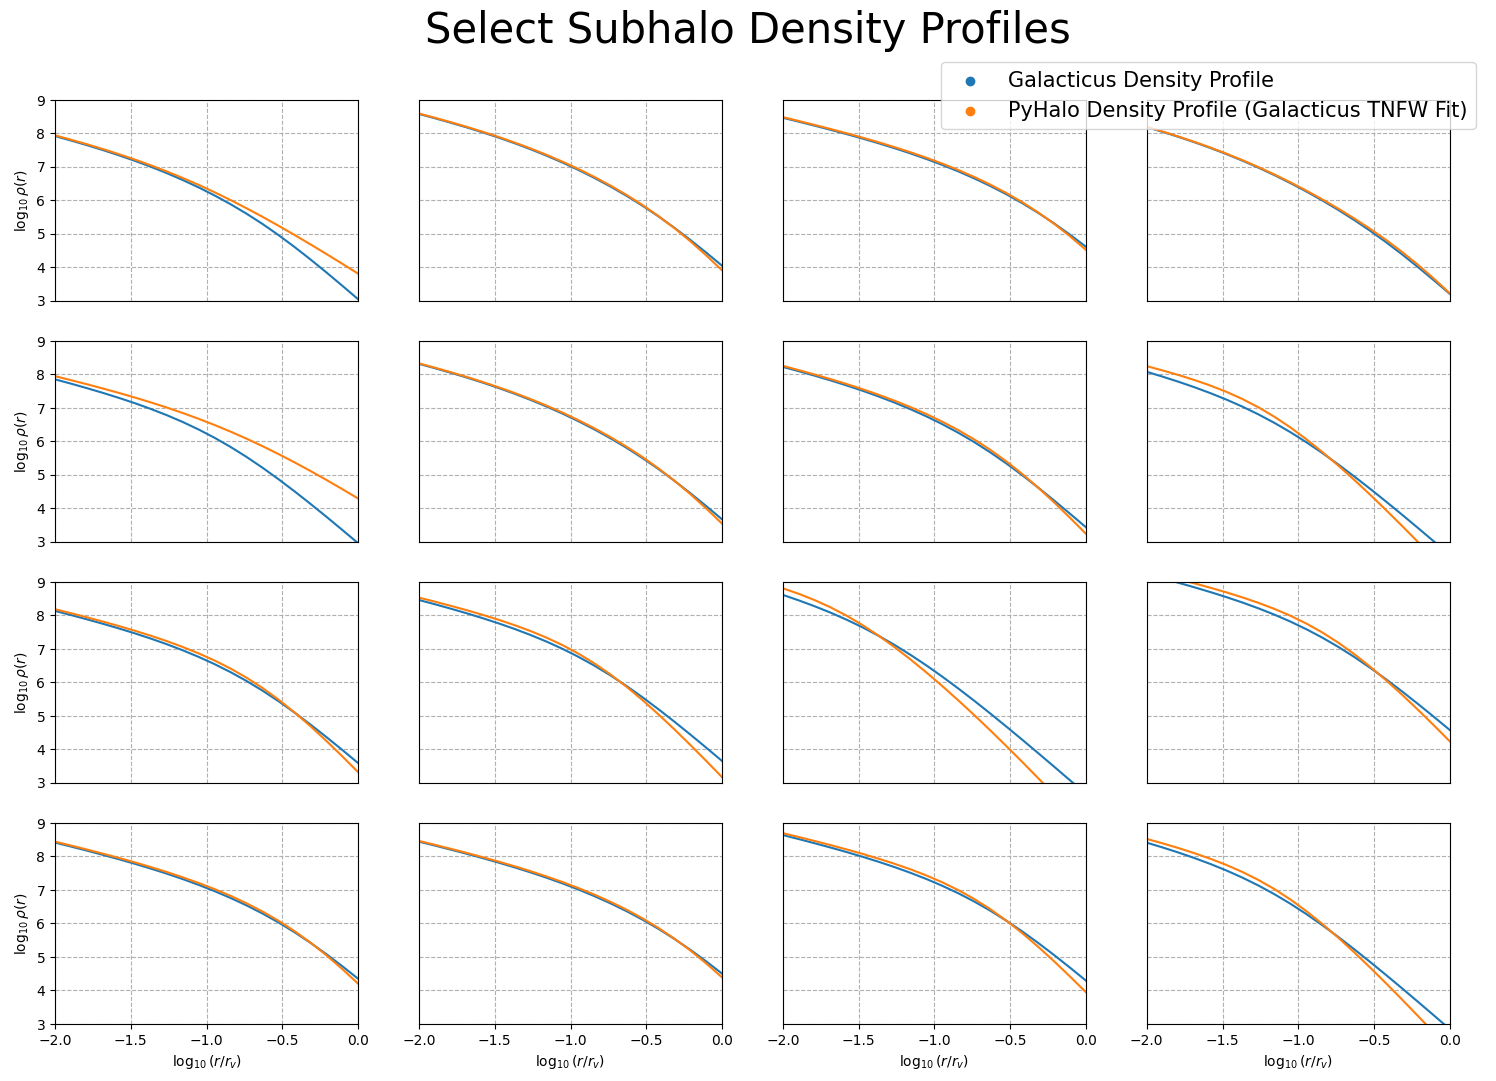

In [12]:
nplotsx, nplotsy = 4,4
xscale = (-2,0)
yscale = (3,9)
fig, axs = plt.subplots(nplotsy,nplotsx,figsize=(18,12))

def plot_galacticus_profile(ax:plt.Axes,nodedata:dict[str,np.ndarray],id,gutil:GalacticusUtil):
    nd_sub = nodedata_apply_filter(nodedata,nodedata[gutil.PARAM_NODE_ID] == id)

    density_profile_radius = nd_sub[gutil.PARAM_DENSITY_PROFILE_RADIUS][0]
    density_profile = nd_sub[gutil.PARAM_DENSITY_PROFILE][0] / 1E9
    rv = nd_sub[gutil.PARAM_RADIUS_VIRIAL][0] 

    ax.plot(np.log10(density_profile_radius / rv),np.log10(density_profile),label="Galacticus Density Profile")

def plot_pyhalo_density_profile(ax:plt.Axes,subhalo:TNFWFromParams, nodedata, gutil:GalacticusUtil):
    id = subhalo.id
    
    nd_sub = nodedata_apply_filter(nodedata,nodedata[gutil.PARAM_NODE_ID] == id)

    density_profile_radius = nd_sub[gutil.PARAM_DENSITY_PROFILE_RADIUS][0] * 1E3
    rv = subhalo.params_physical[TNFWFromParams.KEY_RV]

    density_profile = subhalo.density_profile_3d(density_profile_radius)

    ax.plot(np.log10(density_profile_radius / rv),np.log10(density_profile),label="PyHalo Density Profile")



for y,ax_row in enumerate(axs):
    for x,ax in enumerate(ax_row):
        _ax:plt.Axes = ax

        _ax.set_xlim(*xscale,)
        _ax.set_ylim(*yscale)
        _ax.set_xlabel(r"$\log_{10}(r/r_v)$")
        _ax.set_ylabel(r"$\log_{10}\rho(r)$")
        _ax.grid(linestyle="--")

        if x > 0:
            _ax.tick_params(left=False,labelleft=False)
            _ax.set_ylabel("")
        if y < nplotsy - 1:
            _ax.tick_params(bottom=False,labelbottom=False)
            _ax.set_xlabel("")

        n = nplotsx * y + x

        sh = subhalos[n]

        plot_galacticus_profile(ax,nodedata,sh.id,gutil)
        plot_pyhalo_density_profile(ax,sh,nodedata,gutil)

ax_main = fig.add_axes((0.1,0.1,0.82,0.82),facecolor=(1,1,1,0))
ax_main.axis("off")

ax_main.set_title("Select Subhalo Density Profiles",fontdict=dict(fontsize=30))
ax_main.set_xlim((0,1))
ax_main.set_ylim((0,1))

ax_main.scatter((-10,),(-10,),label="Galacticus Density Profile")
ax_main.scatter((-10,),(-10,),label="PyHalo Density Profile (Galacticus TNFW Fit)")

ax_main.legend(loc="upper right",fontsize=15)



Right now there appears to be an issue with the $r_t$ fits from galacticus. Until this gets fixed we can fit the density profiles in python.

In [217]:
# This code is Andrew Benson's TNFW fitting algorithm re written in python
# see https://github.com/galacticusorg/galacticus/blob/7929a8eaaa3b36fee72cb343abe04644cbf3bc22/source/nodes.property_extractor.tidally_truncated_NFW_fit.F90

def fitmetric(logrt:float, r:np.ndarray, rho:np.ndarray, rho0:float, rs:float):
    rt = np.exp(logrt)

    select = r > 0.1 * rs
    r = r[select]

    tnfwovernfw = 1/(1 + (r/rt)**2)

    x = r / rs
    nfw = rho0/(x * (1 + x)**2)

    rhoovernfw = rho[select] / nfw

    metric = np.sum((np.log10(rhoovernfw / tnfwovernfw))**2)

    return metric


def fit_rt(r:np.ndarray, rho:np.ndarray, rho0:float, rs:float,rv,**kwargs):
    return minimize(fitmetric,np.log(rv),(r,rho,rho0,rs),method="Nelder-Mead",bounds=((None,None),))

def fit_rt(nodedata,gutil:GalacticusUtil):
    nodecount = nodedata[nodedata.__iter__().__next__()].shape[0]

    #print(nodecount)
    rt = np.zeros(nodecount)

    for n,sh in enumerate(gutil.NodeIterator(nodedata)):
        r = sh[gutil.PARAM_DENSITY_PROFILE_RADIUS]
        
        rho_r = sh[gutil.PARAM_DENSITY_PROFILE]

        rho_0 = sh[gutil.PARAM_TNFW_RHO_S] * 4

        rs = sh[gutil.PARAM_RADIUS_SCALE]
        rv = sh[gutil.PARAM_RADIUS_VIRIAL]

        fit = fit_rt(r,rho_r,rho_0,rs,rv)
        rt[n] = np.exp(fit["x"][0])

    return rt * 1E3


In [218]:
realization_galacticus_subhalos_custom_fit = DMFromGalacticus(z_lens,z_source,path_hdf5,tree_index,dict(cone_opening_angle_arcsec=cone_opening_angle_arcsec),
                                                                                mrange,True,plane_normal,include_field_halos=False,
                                                                                galacticus_params_additional=(gutil.PARAM_DENSITY_PROFILE,gutil.PARAM_DENSITY_PROFILE_RADIUS),
                                                                                tabulate_radius_truncation=fit_rt)

subhalos_custom_fit = realization_galacticus_subhalos_custom_fit.halos

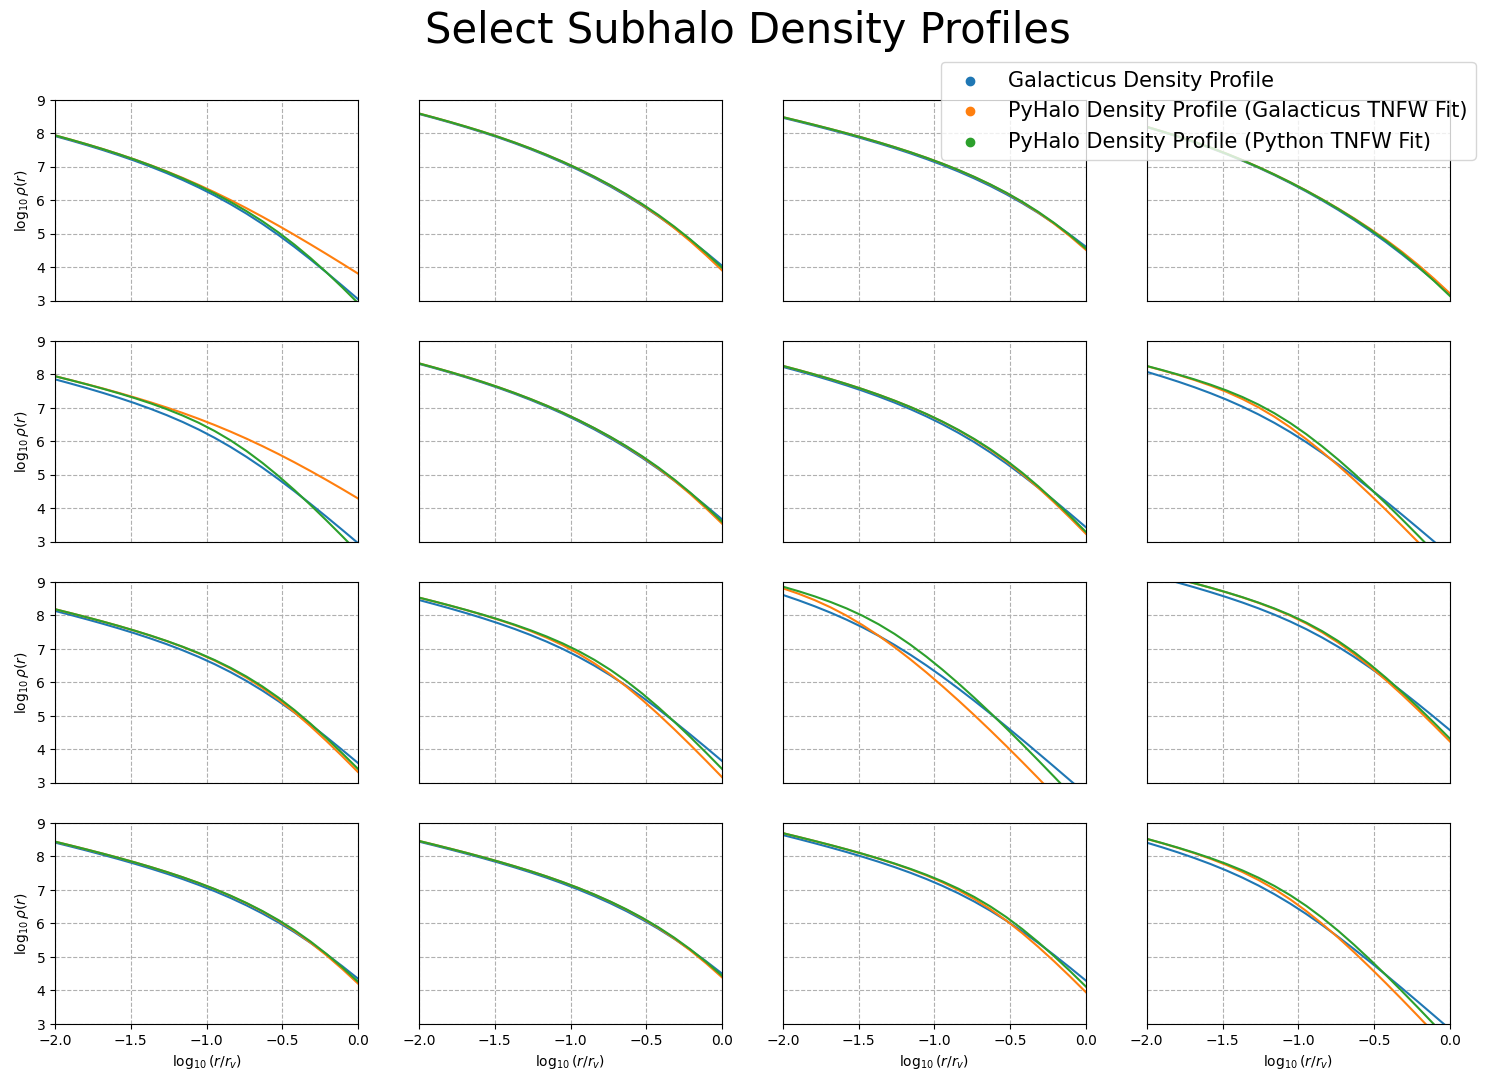

In [219]:
fig, axs = plt.subplots(nplotsy,nplotsx,figsize=(18,12))


for y,ax_row in enumerate(axs):
    for x,ax in enumerate(ax_row):
        _ax:plt.Axes = ax

        _ax.set_xlim(*xscale,)
        _ax.set_ylim(*yscale)
        _ax.set_xlabel(r"$\log_{10}(r/r_v)$")
        _ax.set_ylabel(r"$\log_{10}\rho(r)$")
        _ax.grid(linestyle="--")

        if x > 0:
            _ax.tick_params(left=False,labelleft=False)
            _ax.set_ylabel("")
        if y < nplotsy - 1:
            _ax.tick_params(bottom=False,labelbottom=False)
            _ax.set_xlabel("")

        n = nplotsx * y + x

        sh = subhalos[n]
        sh_cust_fit = subhalos_custom_fit[n]

        plot_galacticus_profile(ax,nodedata,sh.id,gutil)
        plot_pyhalo_density_profile(ax,sh,nodedata,gutil)
        plot_pyhalo_density_profile(ax,sh_cust_fit,nodedata,gutil)

ax_main = fig.add_axes((0.1,0.1,0.82,0.82),facecolor=(1,1,1,0))
ax_main.axis("off")

ax_main.set_title("Select Subhalo Density Profiles",fontdict=dict(fontsize=30))
ax_main.set_xlim((0,1))
ax_main.set_ylim((0,1))

ax_main.scatter((-10,),(-10,),label="Galacticus Density Profile")
ax_main.scatter((-10,),(-10,),label="PyHalo Density Profile (Galacticus TNFW Fit)")
ax_main.scatter((-10,),(-10,),label="PyHalo Density Profile (Python TNFW Fit)")

ax_main.legend(loc="upper right",fontsize=15)